In [26]:
import pandas as pd
from pandas.plotting import autocorrelation_plot

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%matplotlib inline

plt.rcParams['figure.figsize']=[40,20]
plt.rcParams['font.size']=22
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.titlesize'] = 28
plt.rcParams['axes.labelsize'] = 24

# Analyze Epidemics Mortality Rate

## SARS

In [76]:
# import sars time series and drop URL column
sars_ts = pd.read_excel('data/SARS.xlsx', usecols=list(range(4)), parse_dates=[1]).set_index('Date', drop=True)

## Estimate Hazard Rate

### Calculate $\alpha_{SARS}$

First, we must calculate the survival rate $S_{SARS}$ from our data. A value of $90.36\%$ is in line with the rate in [this paper](doi:10.1016/j.socscimed.2006.08.004) (as per Wikipedia, as I have no access to the paper). 

In [137]:
S_sars = 1 - sars_ts.iloc[-1]['Mortality'] / sars_ts.iloc[-1]['Infected']
S_sars

0.9036387341472087

### Brute Force Optimization

Drop negative diffs caused by reclassification / discarded cases.

In [141]:
adjusted_sars_ts = sars_ts.diff().resample('D').sum()

In [142]:
def estimate_death_curve(X, d, S):
    alpha_space = np.linspace(0.0001, 0.1, 1000)

    minimum_distance = None
    
    T = X.size
    d_hat = np.zeros(T)

    for alpha in alpha_space:
        K = int(np.round(np.log(S) / np.log(1 - alpha)))

        d_hat = np.zeros(T)

        for t in range(T):
            if t - K > 0:
                d_hat[t] = sum(((1 - alpha) ** k) * X[t - k] for k in range(t-K + 1))
            else:
                # is this correct?
                d_hat[t] = X[t]

        d_hat *= alpha

        distance = np.linalg.norm(d - d_hat)

        if minimum_distance is None or distance < minimum_distance:
            minimum_distance = distance

    return pd.DataFrame.from_dict({"d": d, "d_hat": d_hat})

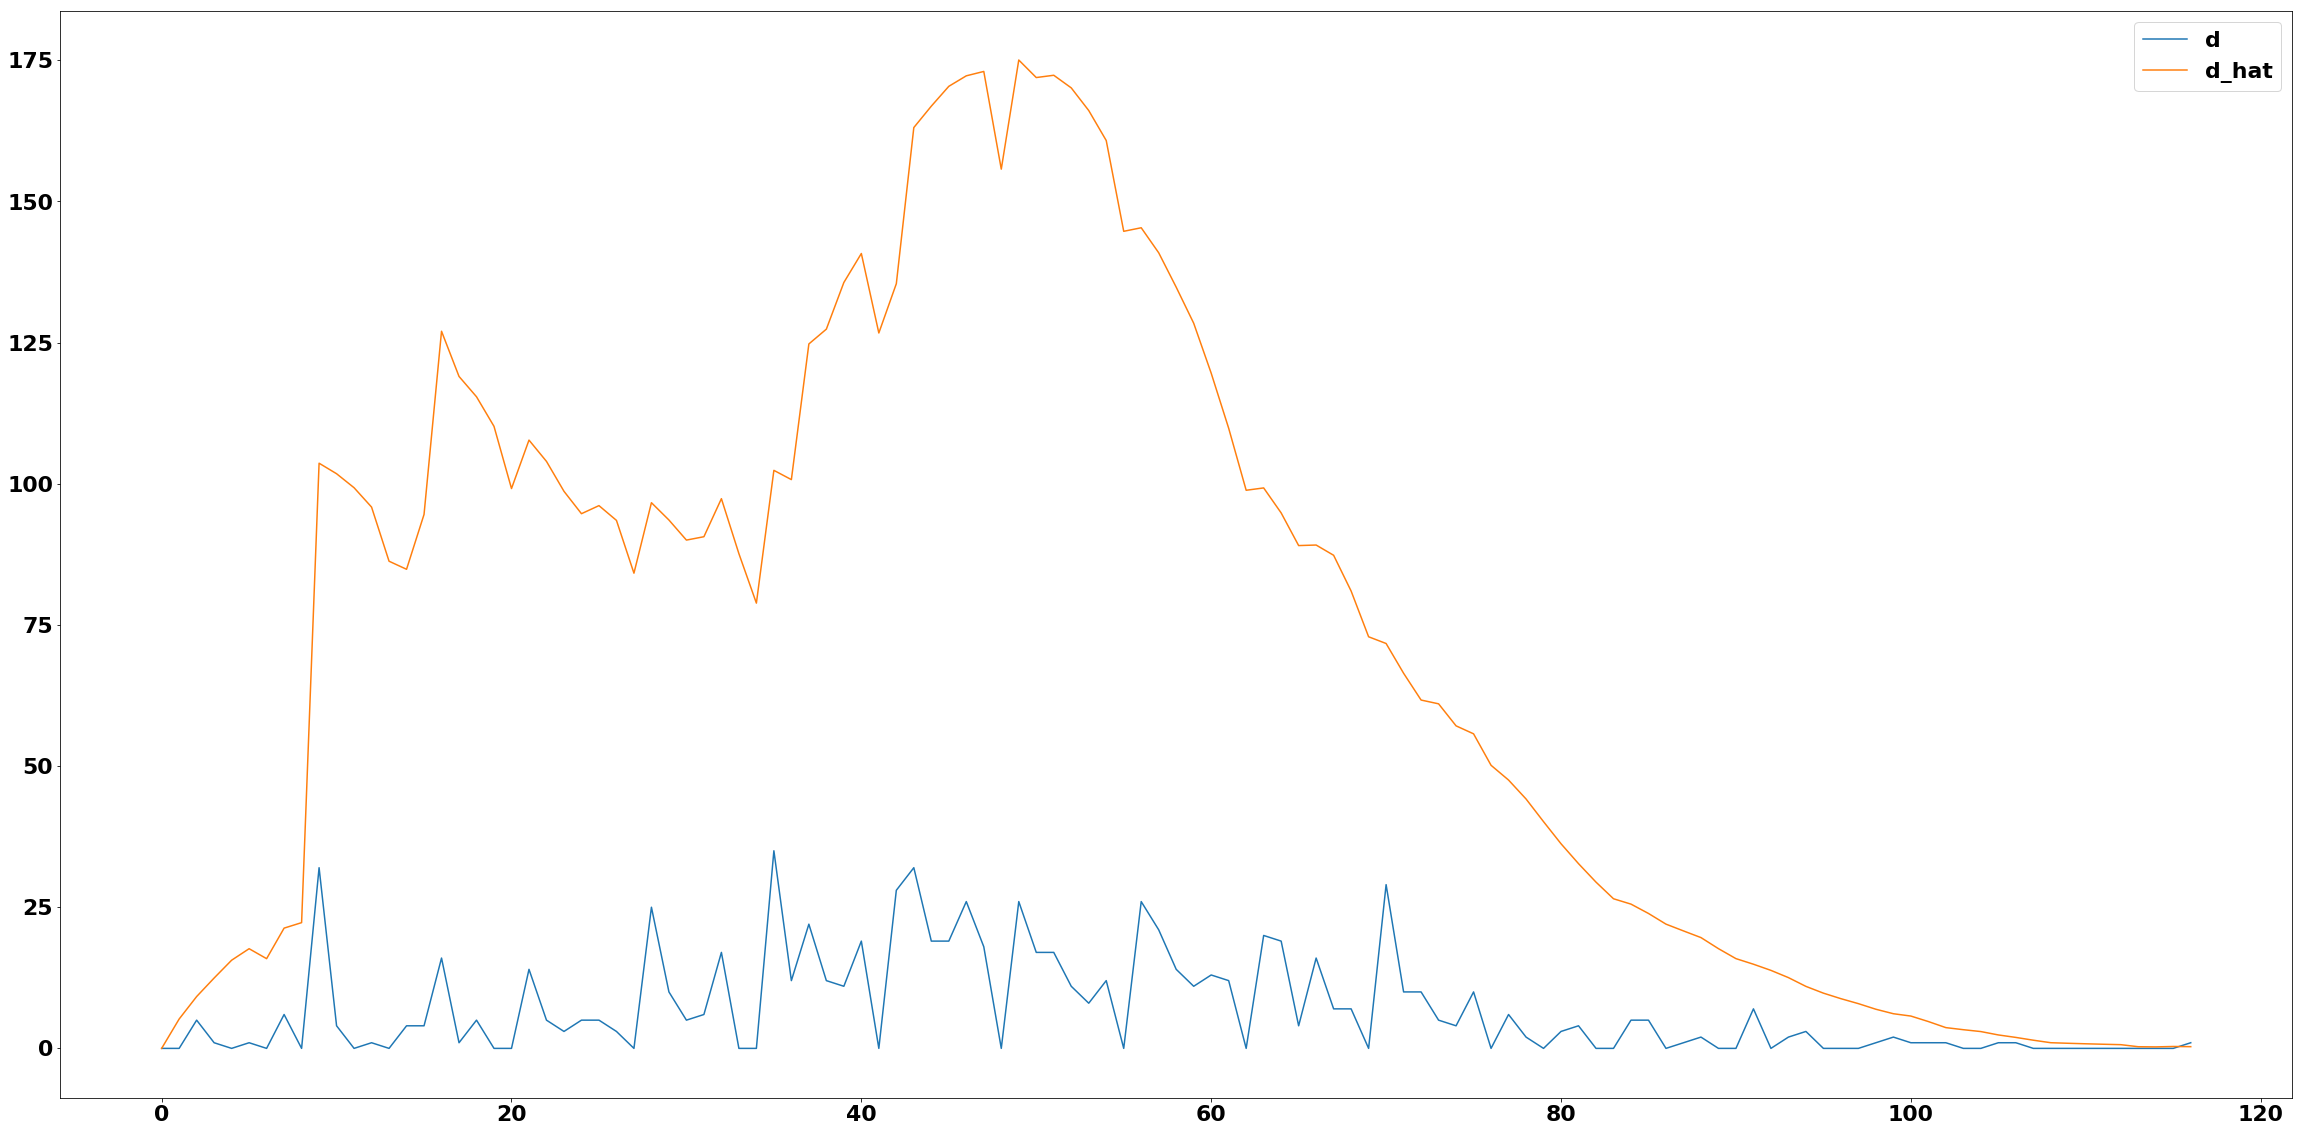

In [143]:
estimate_death_curve(
    adjusted_sars_ts['Infected'].values,
    adjusted_sars_ts['Mortality'].values,
    S_sars
).plot()

## MERS

In [80]:
def calculate_survival_rate(ts):
    return 1 - ts.iloc[-1]['Dead'] / ts.iloc[-1]['Infected']

In [81]:
mers_ts = pd.read_csv('data/MERS/MERS_middle_east_timeline.csv', parse_dates=[0], index_col=0)

In [131]:
adjusted_mers_ts = mers_ts.diff().resample('3D').sum()

In [144]:
S_mers = calculate_survival_rate(mers_ts)
S_mers

0.7354709418837675

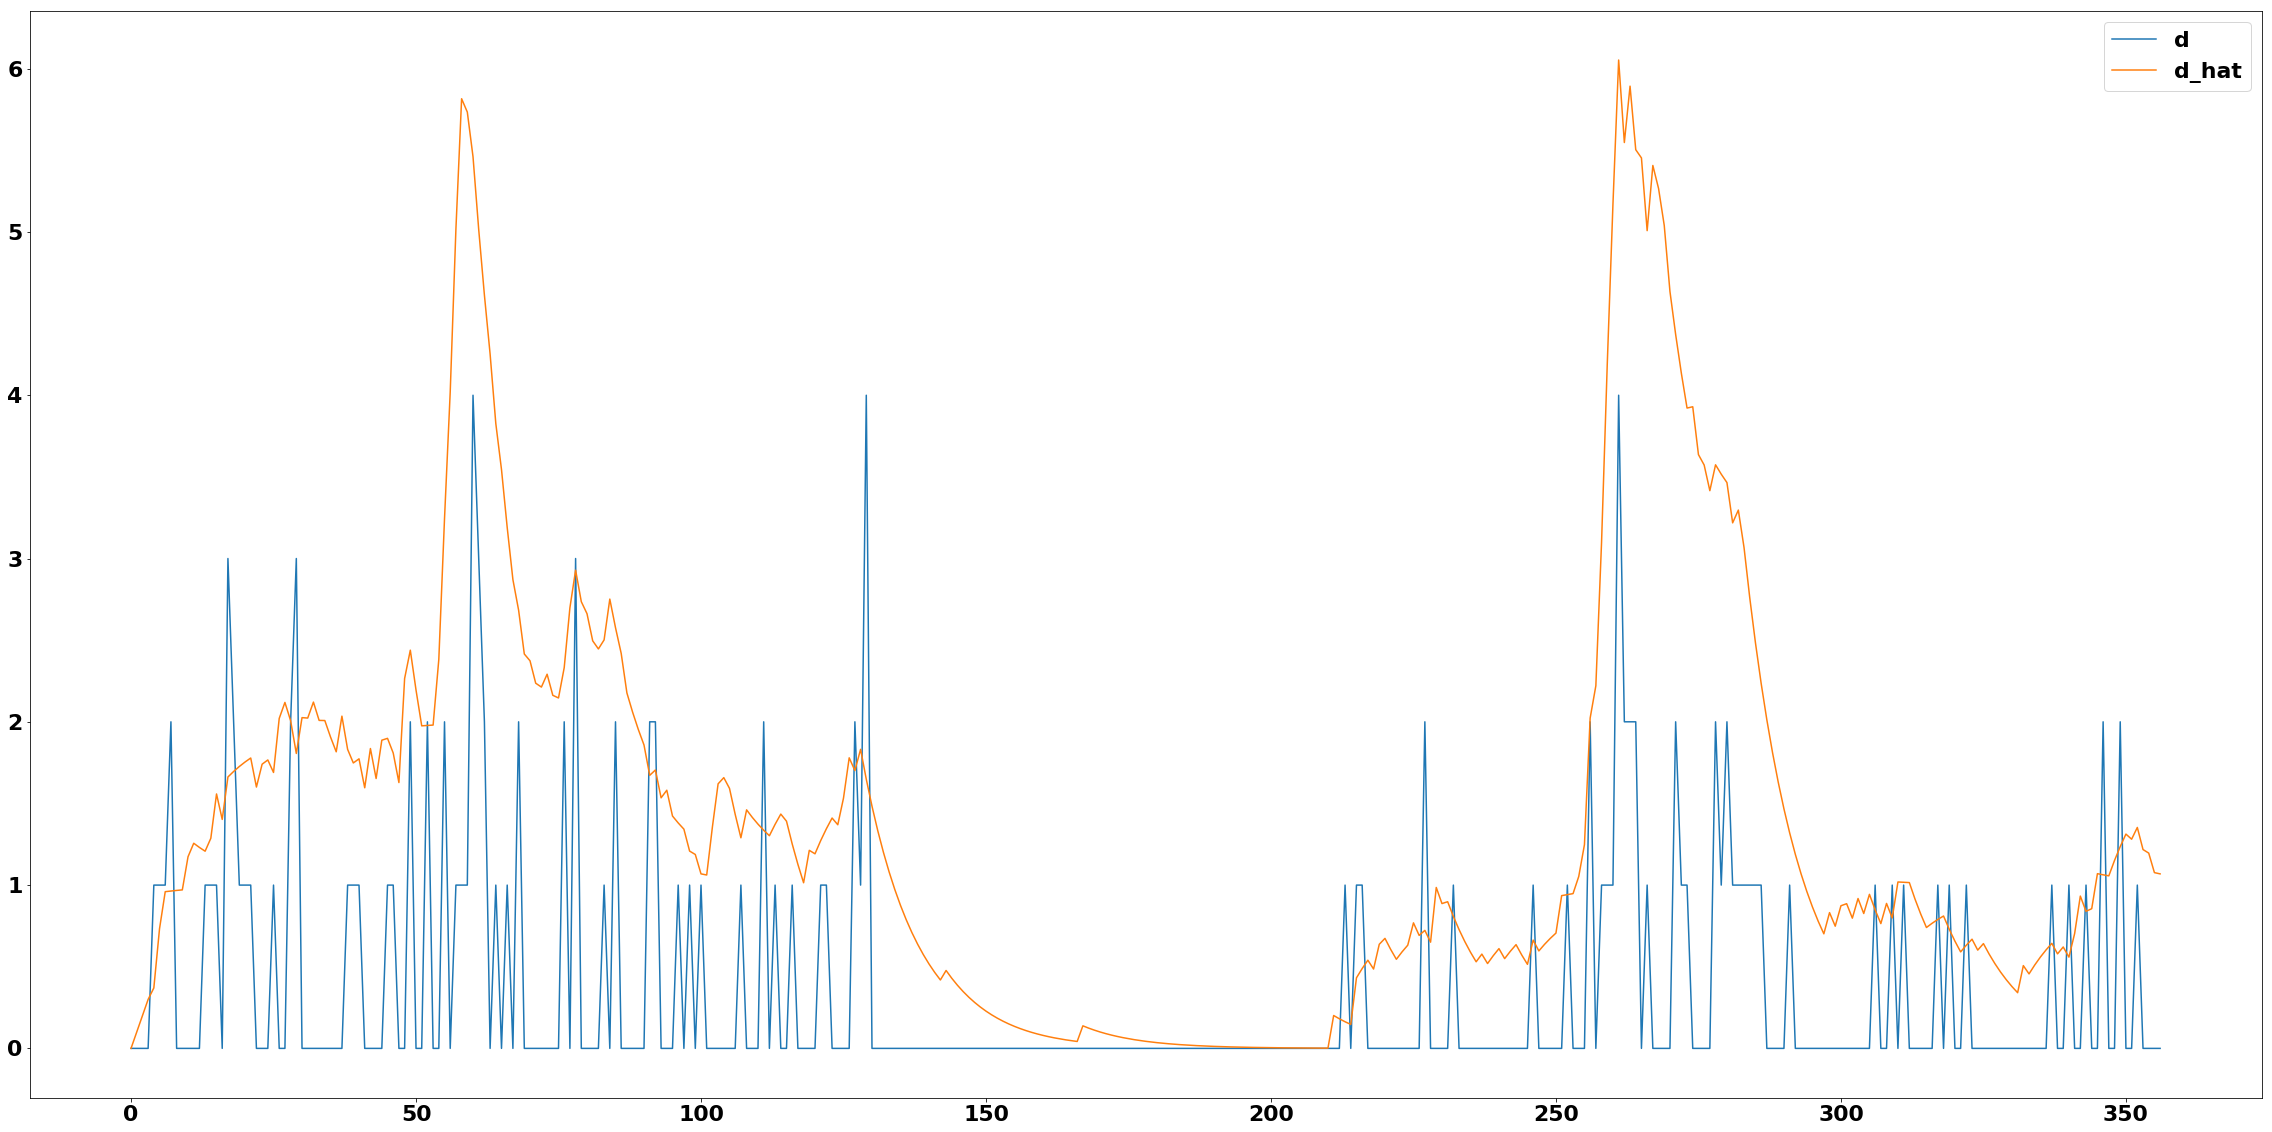

In [133]:
estimate_death_curve(
    adjusted_mers_ts['Infected'].values,
    adjusted_mers_ts['Dead'].values,
    S_mers
).plot()

Clearly, there are two sepeare outbreaks in this dataset. One ending before week 60 (seems like week 57) and the other starting at week 90.

In [134]:
first_mers_ts = adjusted_mers_ts.loc[:"2018-01-28"]
second_mers_ts = adjusted_mers_ts.loc["2018-09-09":]

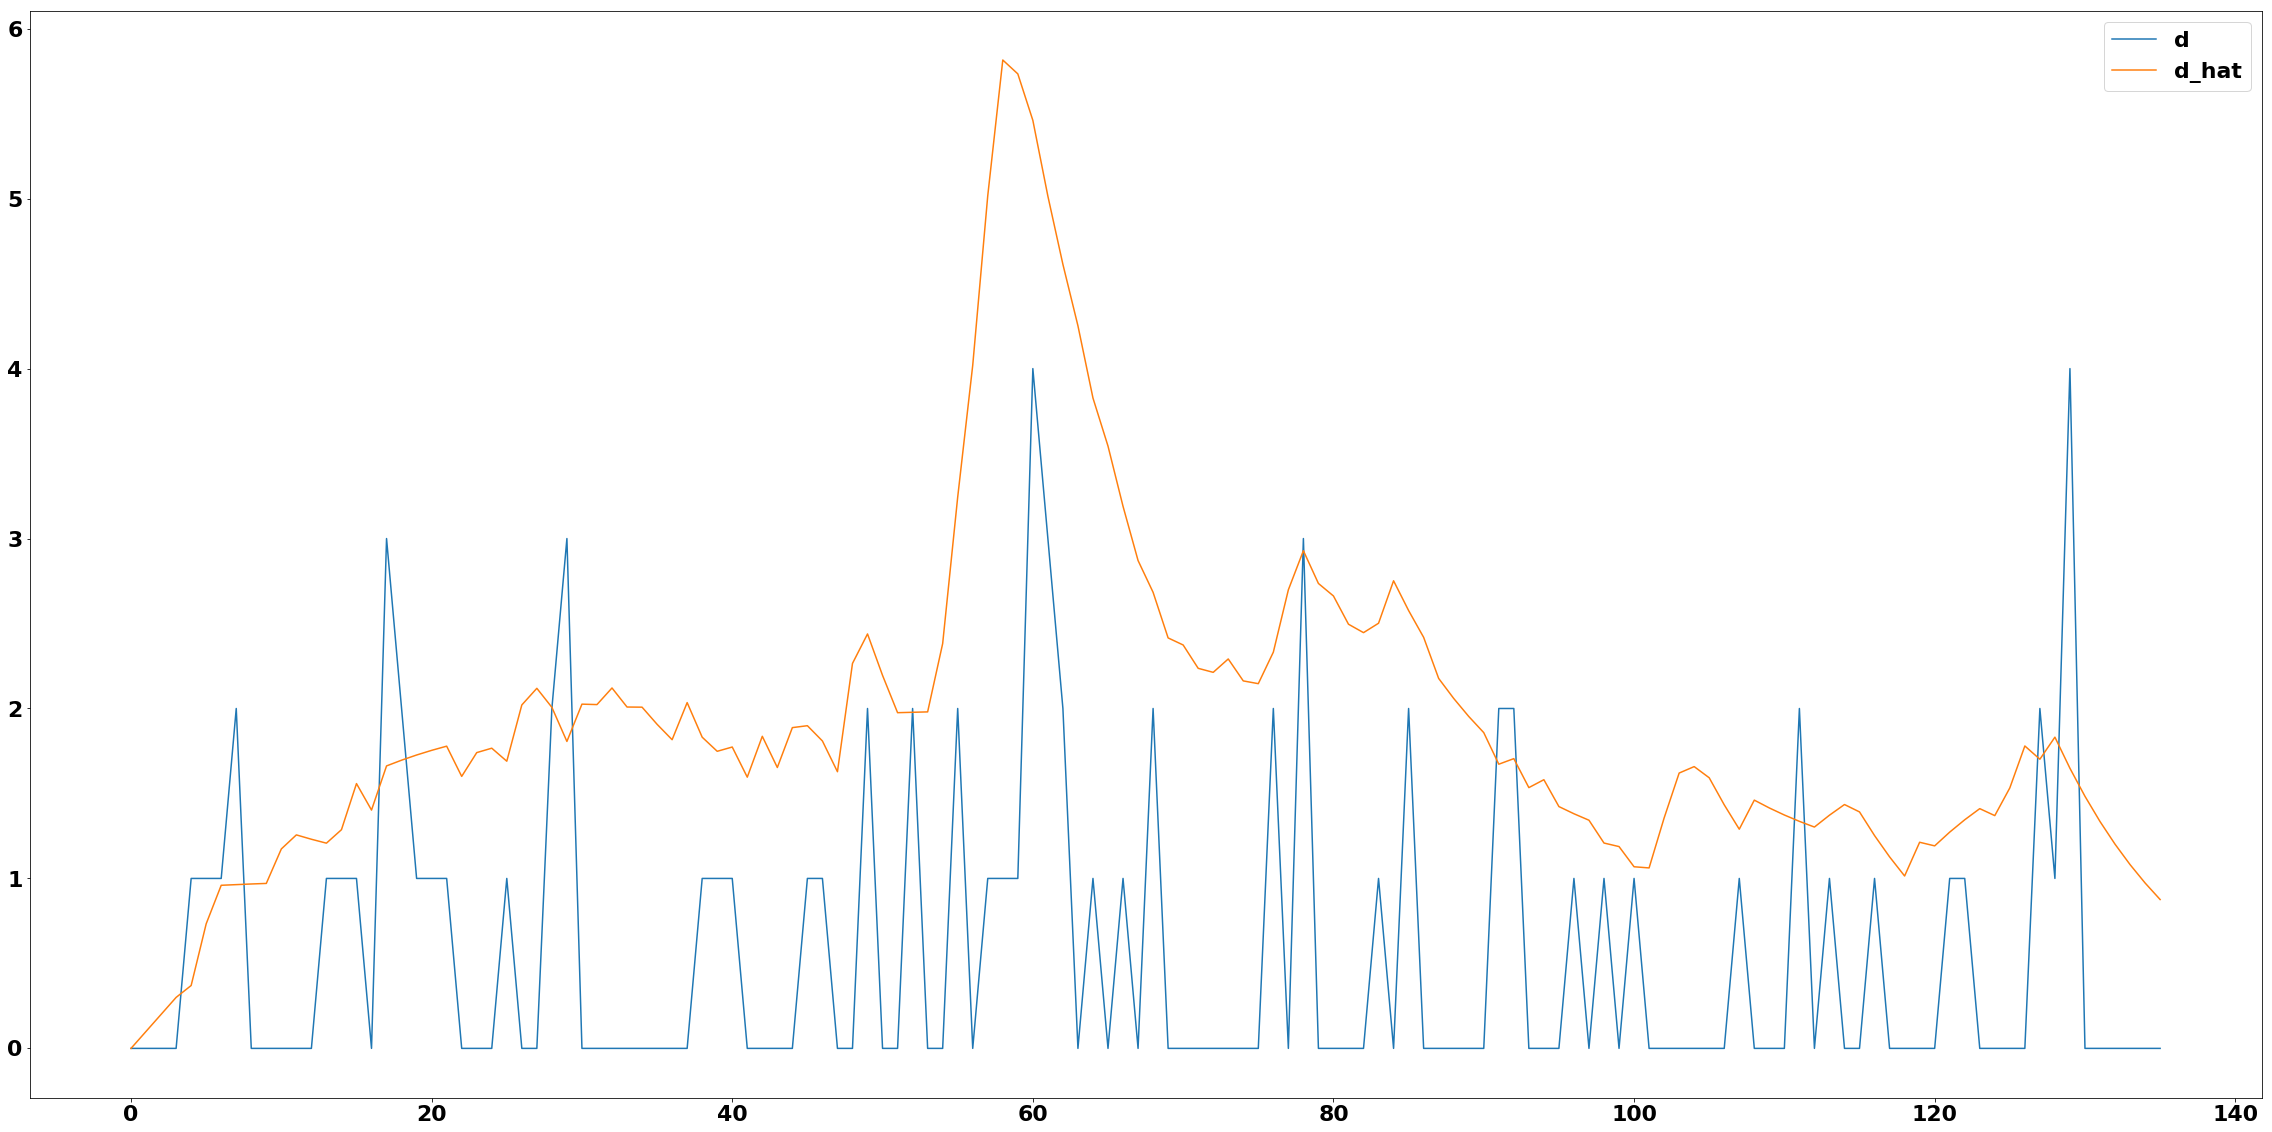

In [135]:
estimate_death_curve(
    first_mers_ts['Infected'].values,
    first_mers_ts['Dead'].values,
    S_mers
).plot()

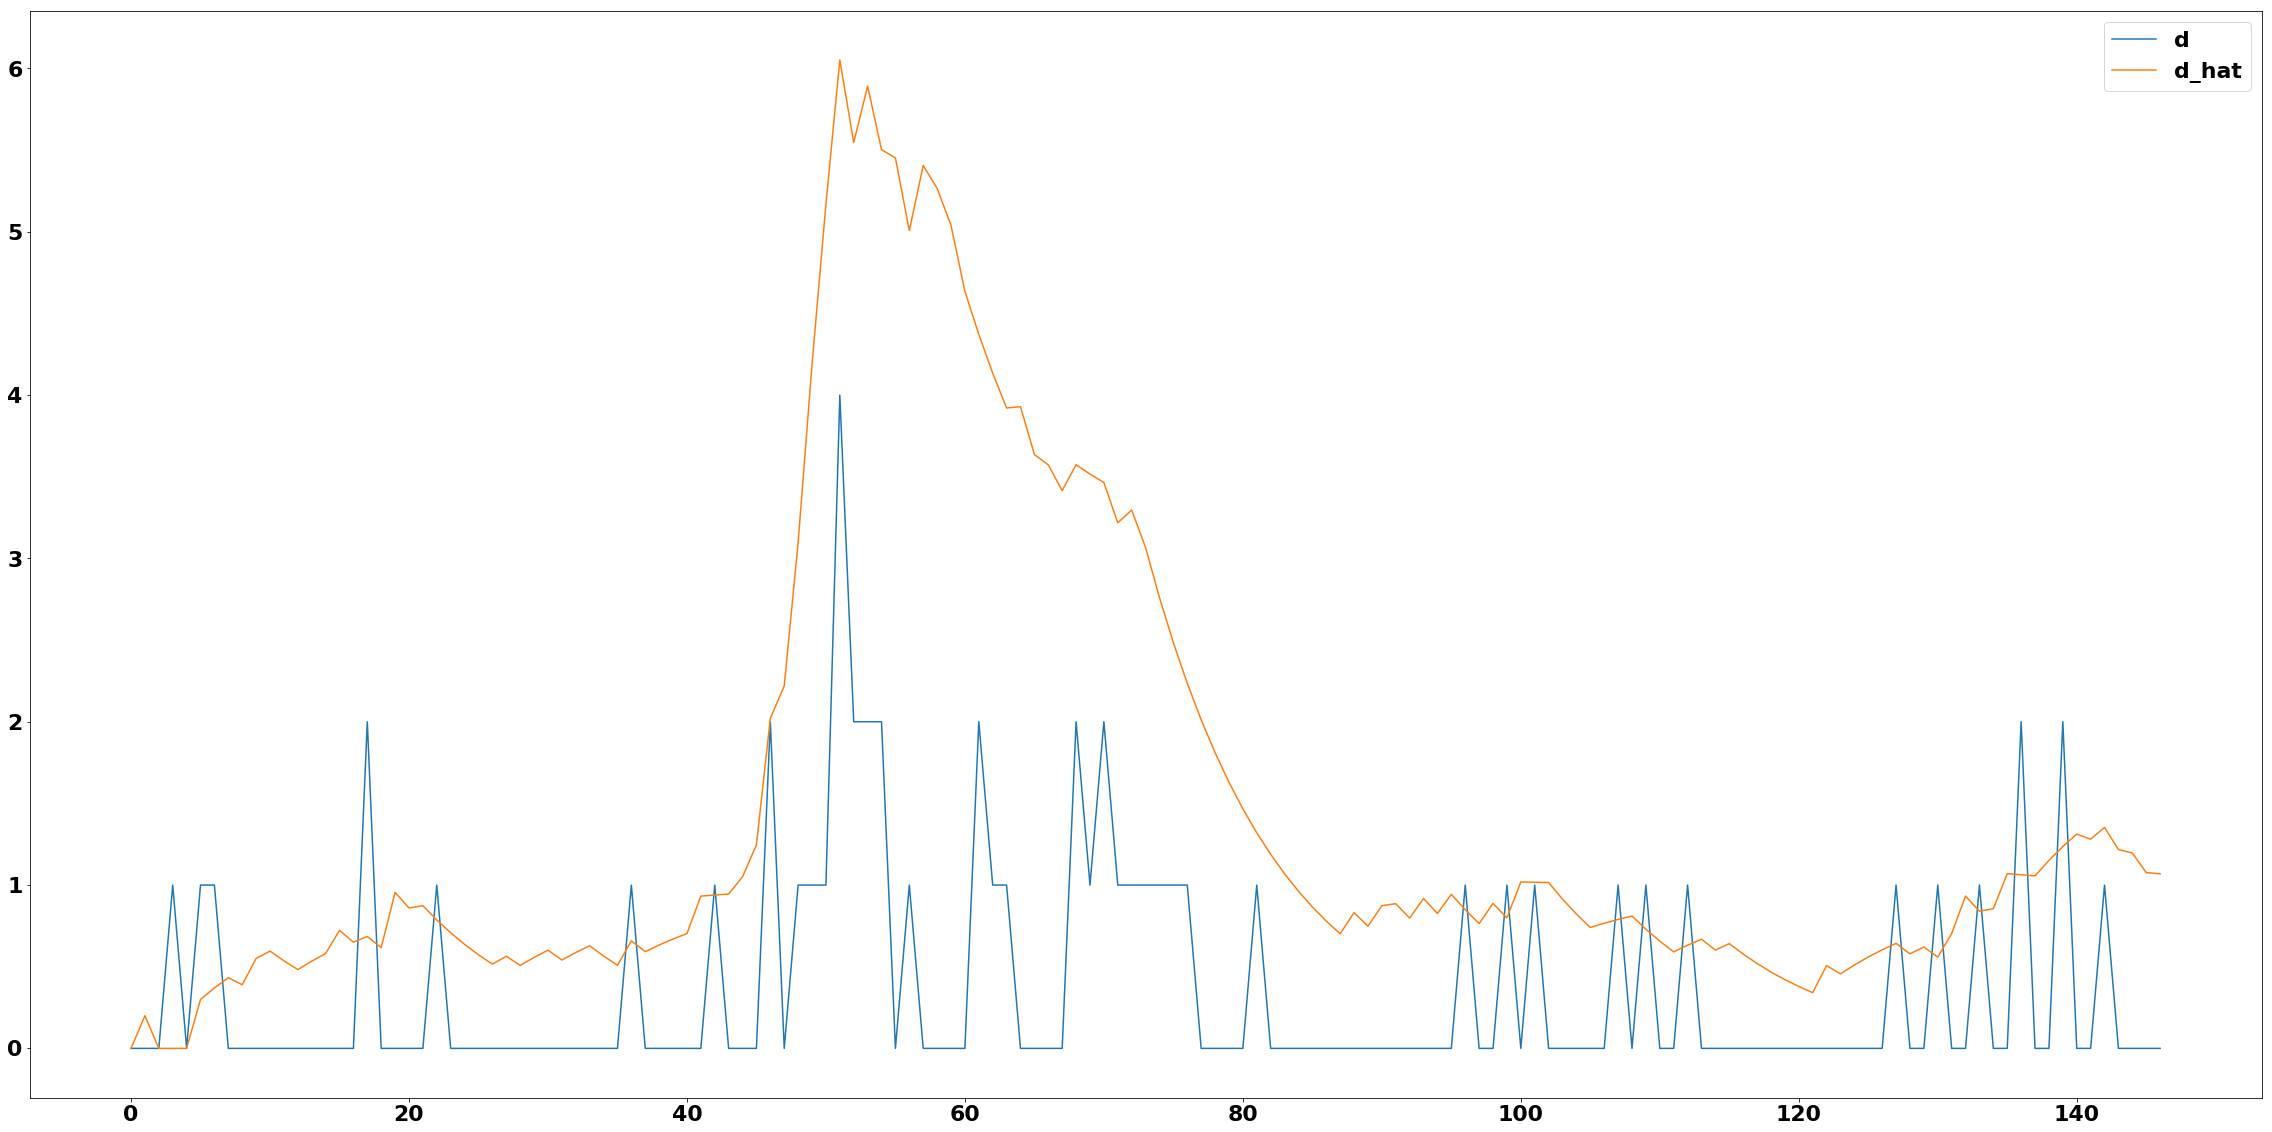

In [136]:
estimate_death_curve(
    second_mers_ts['Infected'].values,
    second_mers_ts['Dead'].values,
    S_mers
).plot()